#### SUM main + ExMAS + MSA


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy import optimize

import ExMAS.utils
from ExMAS.utils import inData
from src import functions as fncs
import random

In [2]:
OTP_API = "http://localhost:8080/otp/routers/default/plan"
params = ExMAS.utils.get_config('data/configs/default_SUM.json')

In [3]:
# Load graph
inData = ExMAS.utils.load_G(inData, params, stats=True)

In [4]:
# Read files with data: Krakow zones and their centroids
gdf_zones = gpd.read_file('data/krk.geojson')
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')

<Axes: >

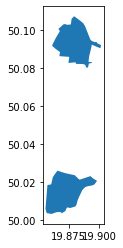

In [5]:
# Read SUM areas: Bronowice and Skotniki
gdf_areas = gpd.read_file('data/sum_areas/sum_areas_B+S.shp')
gdf_areas = gdf_areas.rename(columns={"nazwa": "name"})
# transform coordinate system to EPSG:4326
gdf_areas = gdf_areas.to_crs(4326) 
gdf_areas.plot()

In [6]:
gdf_areas

,name,geometry
0,Bronowice Wielkie,"POLYGON ((19.87805 50.08284, 19.87469 50.08260..."
1,Skotniki,"POLYGON ((19.88842 50.01723, 19.88734 50.01662..."


In [7]:
# Read ODMs and calculate the "probabilities" for destinations
od = pd.read_excel('data/krk_ODM.xlsx', 'AM_peak_PuT', skiprows=[1, 2])
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
# filter OD zone number to match city zones and recalculate sum for origins
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od['sum'] = od.loc[:, 1:].sum(axis=1)
# calculate destination "probability" for each origin point
od_probs = pd.concat([od['zone_NO'], 
            od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)], axis=1)

In [8]:
# Read demographic of the city, clean data
df_demo = pd.read_csv('data/krk_demographic.csv', index_col=0)
df_demo = df_demo.rename(columns={"adr_pelny": "address", "ogolem": "total" })
# assign new coordinates for addresses from outside the city zone
filter = ['STAREGO DĘBU' in i for i in df_demo['address']]
df_demo.loc[filter, 'x'], df_demo.loc[filter, 'y'] = 19.872702, 50.100578
# assign zone number to each address point
df_demo['zone_NO'] = df_demo.apply(lambda row: 
                                   fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
# remove the trips with nan zone
df_demo.dropna(subset='zone_NO', inplace=True, ignore_index=True)

In [9]:
# Chosen hub locations for each area
hubs = {"Bronowice Wielkie": (19.88192, 50.08179), "Skotniki": (19.88948, 50.01844)}

#### Run simulations

In [ ]:
# simulations testing - version 25.10
N = 1
iterations = 500
degree = 6
ASC = 2.3
areas_res = {} # resulting dataFrame with averages
sum_res = {} # resulting dataFrame from the last iteration
avg_times = {} # dataframe to store average times for each area
times = {} # dictionary to store dataframes with times: {'Skotniki': {t_0, ttrav_sh_i, t_expected_i}}

for _, area in gdf_areas.iterrows():
    key = area["name"]
    dfres = pd.DataFrame()
    
    for repl in range(N):
        df_times = pd.DataFrame()
        avg_time = []
        area_reqs = fncs.define_demand(area, df_demo, gdf_centroid, od, od_probs, params)
        df = area_reqs[key].copy() # df with {O, D, Treq} for the area
        hub = hubs[key]
        print("run simulations for area", key, " sample size ", df.shape[0])

        # OPTION I: Utility for PT OD
        u_pt_od = df.copy()
        u_pt_od = fncs.run_OTP(u_pt_od, OTP_API) # define PT routes for each traveller
        fncs.PT_utility(u_pt_od, params)  
        
        df = df.loc[u_pt_od.index, :] # select requests with successful OD trips 
        df.reset_index(drop=True, inplace=True)

        # OPTION II: Utility for SUM (SINGLE TRIPS OH + PT HD)
        df_sum = df.copy()

        # Utility for SINGLE TRIPS OH
        df_sum['origin'] = df_sum.apply(lambda row: ox.nearest_nodes(inData.G, row['origin_x'], row['origin_y']), axis=1)
        df_sum['destination'] = ox.nearest_nodes(inData.G, hub[0], hub[1])
        df_sum['dist'] = df_sum.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
        df_sum['ttrav'] = df_sum['dist'].apply(lambda request: request / params.avg_speed)
        df_sum['tarr'] = df_sum.treq + df_sum.apply(lambda df_sum: pd.Timedelta(df_sum.ttrav, 's').floor('s'), axis=1)
        df_sum['t_expected'] = df_sum['ttrav'] # optimistic ttrav -> changed t_0 to t_expected
        
        # Utility for PT HD
        u_pt_hd = df_sum[['origin_x', 'origin_y', 'destination_x', 'destination_y', 'tarr']]
        # change origin x, y to hub coordinates
        u_pt_hd['origin_x'] = hub[0]
        u_pt_hd['origin_y'] = hub[1]
        # treq for PT_HD = treq + ttrav + transfertime
        u_pt_hd['treq'] = pd.to_datetime(u_pt_hd.tarr) + pd.Timedelta(params.transfertime, unit='s')
        u_pt_hd = fncs.run_OTP(u_pt_hd, OTP_API)
        fncs.PT_utility(u_pt_hd, params)

        u_pt_od = u_pt_od.loc[u_pt_hd.index, :] # drop rows with unsuccessful HD trips 
        u_pt_od.reset_index(drop=True, inplace=True)
        df_sum = df_sum.loc[u_pt_hd.index, :] 
        df_sum.reset_index(drop=True, inplace=True)
        u_pt_hd.reset_index(drop=True, inplace=True)
    
        df_sum['u_PT_OD'] = u_pt_od.u_PT # utility for PT OD
        df_sum['u_PT_HD'] = u_pt_hd.u_PT # utility for PT HD
        # Utility for SUM OD
        df_sum['u_SUM_OD'] = df_sum.apply(lambda request: request['ttrav'] * params.VoT * params.WtS + \
                                          request['dist'] * params.price / 1000, axis=1) + u_pt_hd.u_PT + ASC 
        # probability of using SUM for each traveler in a single trip
        df_sum['p_SUM'] = df_sum.apply(lambda row: math.exp(-row.u_SUM_OD) / \
                                    (math.exp(-row.u_SUM_OD) + math.exp(-row.u_PT_OD)), axis=1)
        print("p_SUM ",  df_sum.p_SUM.mean())
        # times ---------------------------------------------------
        # optimistic ttrav, updated after each ExMAS iteration for travelers using SUM
        df_times['t_0'] = df_sum['ttrav'] 
        avg_time.append(df_sum.ttrav.mean()) # optimistic average travel time for ALL travelers
        
        if degree > 1: 
            for i in range(1, iterations + 1):
                print('iteration ', i)
                sum_demand = df_sum[df_sum.apply(lambda row: random.random() < row['p_SUM'], axis=1)] # chosen SUM travelers
                print('sum_demand sample', sum_demand.shape[0])
                df_sum_sh = sum_demand[['origin_x', 'origin_y', 'destination_x', 'destination_y', 'treq', 'origin', 'destination', 'dist', 't_expected', 'u_PT_OD']]
                fncs.run_ExMAS(df_sum_sh, inData, params, hub, degree)
                # sort data after ExMAS shuffled trips to assign ttrav_sh to SUM travelers
                inData_reqs_sorted = inData.sblts.requests.sort_values('index') 
                inData_reqs_sorted.set_index('index', inplace=True)
                inData_reqs_sorted = inData_reqs_sorted.rename_axis(None)
                df_sum_sh['ttrav_sh'] = inData_reqs_sorted['ttrav_sh']
                # 25.10 changes:
                if i == 1:
                    df_sum_sh['t_expected'] = df_sum_sh.ttrav_sh
                else:
                    df_sum_sh['t_expected'] = (i - 1) / i * df_sum_sh.t_expected + df_sum_sh.ttrav_sh / i
                
                df_sum_sh['tarr'] = df_sum_sh.treq + df_sum_sh.apply(
                    lambda req: pd.Timedelta(req.ttrav_sh, 's').floor('s'), axis=1) # 25.10: t_expected changed to req.ttrav_sh
                # ---------------------------------------------------
                avg_time.append(df_sum_sh.t_expected.mean()) # average expected travel times on each iteration
                # dataframe with times: {t_0, t_ttrav_sh_i, t_expected_i}
                df_times.loc[df_sum_sh.index, [f'ttrav_sh_{i}']] = df_sum_sh[['ttrav_sh']].values
                df_times.loc[df_sum_sh.index, [f't_expected_{i}']] = df_sum_sh[['t_expected']].values
                # ---------------------------------------------------
                # assign indexes of shared trips to column 'indexes_sum' and RESET INDEX to calculate OTP
                df_sum_sh.insert(0, 'indexes_sum', df_sum_sh.index)
                df_sum_sh = df_sum_sh.reset_index(drop=True)

                # Utility for PT HD
                u_pt_hd = df_sum_sh[['indexes_sum', 'origin_x', 'origin_y', 'destination_x', 'destination_y', 'tarr']]
                # change origin x, y to hub coordinates
                u_pt_hd['origin_x'] = hub[0]
                u_pt_hd['origin_y'] = hub[1]
                # treq for PT_HD = treq + ttrav_sh = tarr
                u_pt_hd['treq'] = pd.to_datetime(u_pt_hd.tarr)
                u_pt_hd = fncs.run_OTP(u_pt_hd, OTP_API)
                fncs.PT_utility(u_pt_hd, params)

                # drop rows with unsuccessful HD trips only for df_sum_sh (as u_PT_OD is the same as for the single trips)
                df_sum_sh = df_sum_sh.loc[u_pt_hd.index, :] 
                df_sum_sh.reset_index(drop=True, inplace=True)
                u_pt_hd.reset_index(drop=True, inplace=True)
                
                # Utility F OH - ADD t_w from ExMAS.sblts.rides
                df_sum_sh['u_F'] = df_sum_sh.apply(lambda request: request['t_expected'] * params.VoT * params.WtS + \
                                          request['dist'] * params.price / 1000, axis=1) 
                # df_sum['u_PT_OD'] doesn't change for SUM demand
                df_sum_sh['u_PT_HD'] = u_pt_hd.u_PT
                df_sum_sh['u_SUM_OD'] = df_sum_sh.u_F + u_pt_hd.u_PT + ASC
                df_sum_sh['p_SUM'] = df_sum_sh.apply(lambda row: math.exp(-row.u_SUM_OD) / \
                                        (math.exp(-row.u_SUM_OD) + math.exp(-row.u_PT_OD)), axis=1)
                # Update p_SUM  and t_0 for trips chosen for SUM in the main table
                df_sum.loc[df_sum_sh['indexes_sum'], ['p_SUM']] = df_sum_sh[['p_SUM']].values
                df_sum.loc[df_sum_sh['indexes_sum'], ['t_expected']] = df_sum_sh[['t_expected']].values
                # avg_time.append(df_sum.t_0.mean()) # average expected travel times for ALL travelers
                print("p_SUM after ExMAS",  df_sum_sh.p_SUM.mean())
                print("==============================================================")
    
        df_means = pd.DataFrame([[u_pt_od.waitingTime.mean(), u_pt_hd.waitingTime.mean(), u_pt_od.u_PT.mean(),
                                u_pt_hd.u_PT.mean(), df_sum.u_SUM_OD.mean(), df_sum.p_SUM.mean()]], 
                                columns=['tw_PT_OD', 'tw_PT_HD', 'u_PT_OD', 'u_PT_HD', 'u_SUM_OD', 'p_SUM'])
        dfres = pd.concat([dfres, df_means], ignore_index=True)
    sum_res[key] = df_sum
    areas_res[key] = dfres
    times[key] = df_times
    avg_times[key] = avg_time

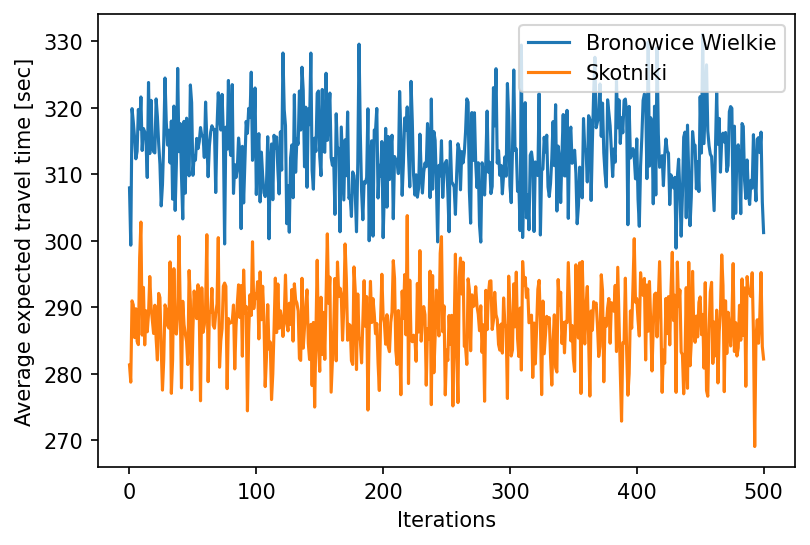

In [ ]:
# convergence of t_expected after changes from 25.10
t_b_500 = avg_times['Bronowice Wielkie']
t_s_500 = avg_times['Skotniki']
plt.figure(dpi=150)
plt.plot(t_b_500, label='Bronowice Wielkie')
plt.plot(t_s_500, label='Skotniki')
plt.xlabel('Iterations')
plt.ylabel('Average expected travel time [sec]')
plt.legend()
plt.show()

In [ ]:
def simulate(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, degree=1, N=1, iterations=1, calc_ASC=False, ASC=5.31):
    '''calculate utilities for each traveller of the given area for single and shared rides (ExMAS)
       calculate ASC if calc_ASC = True
       implement method of successive averages (MSA) for 
    input:  gdf_areas - SUM areas [geopandas dataframe]
            df_demo - city population distribution [csv]
            gdf_centroid - centroids of city zones [geojson]
            od - ODMs [excel], od_probs - dataframe with destination probabilities
            hubs - choseen hub locations [dict]
            inData, params, OTP_API, degree - ExMAS input
            N - number of replications (generate sample for the area)
            iterations - number of iterations for ExMAS
            calc_ASC - flag to calculate ASC
            ASC - alternative specific constant
    output: tuple[0] - dictionary with mean results for N iterations for each area sample
               ex. {'Skotniki': tw_PT_OD, tw_PT_HD, u_PT_OD, u_PT_HD, u_SUM_OD, p_SUM}
            tuple[1] - dictionary with results of the last iteration for sample of each area:
               ex. {'Skotniki': origin_x, origin_y, destination_x, destination_y, treq, u_PT_OD,
                                origin, hub, dist, ttrav, tarr, u, u_SUM_OD, p_SUM}
            '''
    areas_res = {} # resulting dataFrame with averages 
    sum_res = {} # resulting dataFrame from the last iteration
    avg_times = {} # dataframe to store average times for each area
    asc_dict = {} # dictionary with [asc's] for each area
    times = {} # dictionary to store dataframes with times: {'Skotniki': {t_0, ttrav_sh_i, t_expected_i}}

    for _, area in gdf_areas.iterrows():
        key = area["name"]
        dfres = pd.DataFrame()
        ascs = [] # store ASC for each sample

        for repl in range(N):
            df_times = pd.DataFrame()
            avg_time = []
            area_reqs = fncs.define_demand(area, df_demo, gdf_centroid, od, od_probs, params)
            df = area_reqs[key].copy() # df with {O, D, Treq} for the area
            hub = hubs[key]
            print(repl + 1, " run simulations for area", key, " sample size ", df.shape[0])

            # OPTION I: Utility for PT OD
            u_pt_od = df.copy()
            u_pt_od = fncs.run_OTP(u_pt_od, OTP_API) # define PT routes for each traveller
            fncs.PT_utility(u_pt_od, params)  
            
            df = df.loc[u_pt_od.index, :] # select requests with successful OD trips 
            df.reset_index(drop=True, inplace=True)

            # OPTION II: Utility for SUM (SINGLE TRIPS OH + PT HD)
            df_sum = df.copy()

            # Utility for SINGLE TRIPS OH
            df_sum['origin'] = df_sum.apply(lambda row: ox.nearest_nodes(inData.G, row['origin_x'], row['origin_y']), axis=1)
            df_sum['destination'] = ox.nearest_nodes(inData.G, hub[0], hub[1])
            df_sum['dist'] = df_sum.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
            df_sum['ttrav'] = df_sum['dist'].apply(lambda request: request / params.avg_speed)
            df_sum['tarr'] = df_sum.treq + df_sum.apply(lambda df_sum: pd.Timedelta(df_sum.ttrav, 's').floor('s'), axis=1)
            # df_sum['t_0'] = df_sum['ttrav'] # optimistic ttrav
            df_sum['t_expected'] = df_sum['ttrav'] # optimistic ttrav -> changed t_0 to t_expected
            
            # Utility for PT HD
            u_pt_hd = df_sum[['origin_x', 'origin_y', 'destination_x', 'destination_y', 'tarr']]
            # change origin x, y to hub coordinates
            u_pt_hd['origin_x'] = hub[0]
            u_pt_hd['origin_y'] = hub[1]
            # treq for PT_HD = treq + ttrav + transfertime
            u_pt_hd['treq'] = pd.to_datetime(u_pt_hd.tarr) + pd.Timedelta(params.transfertime, unit='s')
            u_pt_hd = fncs.run_OTP(u_pt_hd, OTP_API)
            fncs.PT_utility(u_pt_hd, params)

            u_pt_od = u_pt_od.loc[u_pt_hd.index, :] # drop rows with unsuccessful HD trips 
            u_pt_od.reset_index(drop=True, inplace=True)
            df_sum = df_sum.loc[u_pt_hd.index, :] 
            df_sum.reset_index(drop=True, inplace=True)
            u_pt_hd.reset_index(drop=True, inplace=True)
        
            df_sum['u_PT_OD'] = u_pt_od.u_PT # utility for PT OD
            df_sum['u_PT_HD'] = u_pt_hd.u_PT # utility for PT HD
            # Utility for SUM OD
            df_sum['u_SUM_OD'] = df_sum.apply(lambda request: request['ttrav'] * params.VoT * params.WtS + \
                                            request['dist'] * params.price / 1000, axis=1) + u_pt_hd.u_PT + ASC 
            # probability of using SUM for each traveler in a single trip
            df_sum['p_SUM'] = df_sum.apply(lambda row: math.exp(-row.u_SUM_OD) / \
                                        (math.exp(-row.u_SUM_OD) + math.exp(-row.u_PT_OD)), axis=1)
            
            # ASC calculation
            if calc_ASC:
                ascs.append(optimize.fsolve(lambda x: fncs.calc_E_p_sum(df_sum, x) - params.expected_prob, 0)[0])
            else:
                print("p_SUM ",  df_sum.p_SUM.mean())
                # times ---------------------------------------------------
                # optimistic ttrav, updated after each ExMAS iteration for travelers using SUM
                df_times['t_0'] = df_sum['ttrav']
                avg_time.append(df_sum.ttrav.mean()) # optimistic average travel time for ALL travelers
                
                if degree > 1: 
                    for i in range(1, iterations + 1):
                        print('iteration ', i)
                        sum_demand = df_sum[df_sum.apply(lambda row: random.random() < row['p_SUM'], axis=1)] # chosen SUM travelers
                        print('sum_demand sample', sum_demand.shape[0])
                        df_sum_sh = sum_demand[['origin_x', 'origin_y', 'destination_x', 'destination_y', 'treq', 'origin', 'destination', 'dist', 't_expected', 'u_PT_OD']]
                        fncs.run_ExMAS(df_sum_sh, inData, params, hub, degree)
                        # sort data after ExMAS shuffled trips to assign ttrav_sh to SUM travelers
                        inData_reqs_sorted = inData.sblts.requests.sort_values('index') 
                        inData_reqs_sorted.set_index('index', inplace=True)
                        inData_reqs_sorted = inData_reqs_sorted.rename_axis(None)
                        df_sum_sh['ttrav_sh'] = inData_reqs_sorted['ttrav_sh']
                        if i == 1:
                            df_sum_sh['t_expected'] = df_sum_sh.ttrav_sh
                        else:
                            df_sum_sh['t_expected'] = (i - 1) / i * df_sum_sh.t_expected + df_sum_sh.ttrav_sh / i
                        # ^- if is not needed
                        df_sum_sh['tarr'] = df_sum_sh.treq + df_sum_sh.apply(
                            lambda req: pd.Timedelta(req.ttrav_sh, 's').floor('s'), axis=1) # t_expected changed to req.ttrav_sh
                        # ---------------------------------------------------
                        avg_time.append(df_sum_sh.t_expected.mean()) # average expected travel times on each iteration
                        # dataframe with times: {t_0, t_ttrav_sh_i, t_expected_i}
                        df_times.loc[df_sum_sh.index, [f'ttrav_sh_{i}']] = df_sum_sh[['ttrav_sh']].values
                        df_times.loc[df_sum_sh.index, [f't_expected_{i}']] = df_sum_sh[['t_expected']].values
                        # ---------------------------------------------------
                        # assign indexes of shared trips to column 'indexes_sum' and RESET INDEX to calculate OTP
                        df_sum_sh.insert(0, 'indexes_sum', df_sum_sh.index)
                        df_sum_sh = df_sum_sh.reset_index(drop=True)

                        # Utility for PT HD
                        u_pt_hd = df_sum_sh[['indexes_sum', 'origin_x', 'origin_y', 'destination_x', 'destination_y', 'tarr']]
                        # change origin x, y to hub coordinates
                        u_pt_hd['origin_x'] = hub[0]
                        u_pt_hd['origin_y'] = hub[1]
                        # treq for PT_HD = treq + ttrav_sh = tarr
                        u_pt_hd['treq'] = pd.to_datetime(u_pt_hd.tarr)
                        u_pt_hd = fncs.run_OTP(u_pt_hd, OTP_API)
                        fncs.PT_utility(u_pt_hd, params)

                        # drop rows with unsuccessful HD trips only for df_sum_sh (as u_PT_OD is the same as for the single trips)
                        df_sum_sh = df_sum_sh.loc[u_pt_hd.index, :] 
                        df_sum_sh.reset_index(drop=True, inplace=True)
                        u_pt_hd.reset_index(drop=True, inplace=True)
                        
                        # Utility F OH - ADD t_w from ExMAS.sblts.rides
                        # ??? should we use ttrav_sh instead of t_expected
                        df_sum_sh['u_F'] = df_sum_sh.apply(lambda request: request['t_expected'] * params.VoT * params.WtS + \
                                                request['dist'] * params.price / 1000, axis=1) 
                        # df_sum['u_PT_OD'] doesn't change for SUM demand
                        df_sum_sh['u_PT_HD'] = u_pt_hd.u_PT
                        df_sum_sh['u_SUM_OD'] = df_sum_sh.u_F + u_pt_hd.u_PT + ASC
                        df_sum_sh['p_SUM'] = df_sum_sh.apply(lambda row: math.exp(-row.u_SUM_OD) / \
                                                (math.exp(-row.u_SUM_OD) + math.exp(-row.u_PT_OD)), axis=1)
                        # Update p_SUM  and t_0 for trips chosen for SUM in the main table
                        df_sum.loc[df_sum_sh['indexes_sum'], ['p_SUM']] = df_sum_sh[['p_SUM']].values
                        df_sum.loc[df_sum_sh['indexes_sum'], ['t_0']] = df_sum_sh[['t_expected']].values
                        # avg_time.append(df_sum.t_0.mean()) # average expected travel times for ALL travelers
                        print("p_SUM after ExMAS",  df_sum_sh.p_SUM.mean())
                        print("==============================================================")
                
                df_means = pd.DataFrame([[u_pt_od.waitingTime.mean(), u_pt_hd.waitingTime.mean(), u_pt_od.u_PT.mean(),
                                        u_pt_hd.u_PT.mean(), df_sum.u_SUM_OD.mean(), df_sum.p_SUM.mean()]], 
                                        columns=['tw_PT_OD', 'tw_PT_HD', 'u_PT_OD', 'u_PT_HD', 'u_SUM_OD', 'p_SUM'])
                dfres = pd.concat([dfres, df_means], ignore_index=True)
            # results
            sum_res[key] = df_sum
            areas_res[key] = dfres
            times[key] = df_times
            avg_times[key] = avg_time
        asc_dict[key] = ascs
    return (areas_res, sum_res, avg_times, times, asc_dict)

In [ ]:
results = simulate(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, degree=6, iterations=30)

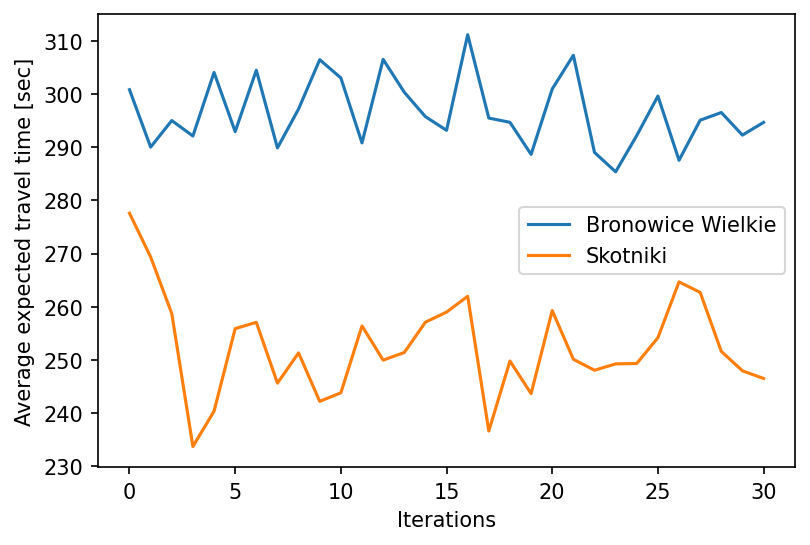

In [ ]:
# convergence of t_expected for 30 iterations (with changes from 25.10)
t_b_30 = results[2]['Bronowice Wielkie']
t_s_30 = results[2]['Skotniki']
plt.figure(dpi=150)
plt.plot(t_b_30, label='Bronowice Wielkie')
plt.plot(t_s_30, label='Skotniki')
plt.xlabel('Iterations')
plt.ylabel('Average expected travel time [sec]')
plt.legend()
plt.show()

#### ASC research

In [ ]:
# save ASCs from 100 iterations to csv (asc_dict)
df_ascs = pd.DataFrame.from_dict(results[4], orient="columns")
df_ascs.to_csv("output/ascs/asc_dict_100.csv")

5.188472484522257


(array([15., 24., 13., 18., 15.,  8.,  7.]),
 array([4.16397663, 4.51383639, 4.86369615, 5.21355591, 5.56341567,
        5.91327542, 6.26313518, 6.61299494]),
 <BarContainer object of 7 artists>)

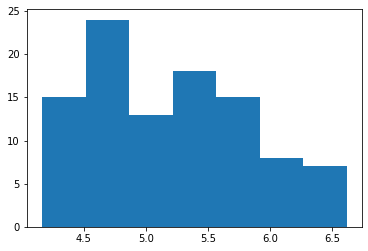

In [ ]:
ascs_b = results[4]['Bronowice Wielkie']
print(sum(ascs_b) / len(ascs_b))
plt.hist(ascs_b, bins=7)

5.4373005733413295 5.312886528931793


(array([26., 45.,  8.,  6.,  5.,  6.,  4.]),
 array([4.78996918, 5.11364196, 5.43731475, 5.76098754, 6.08466033,
        6.40833311, 6.7320059 , 7.05567869]),
 <BarContainer object of 7 artists>)

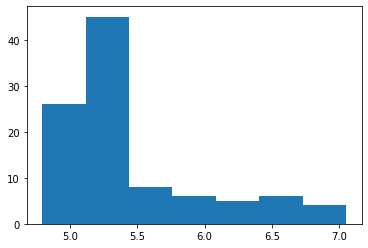

In [ ]:
ascs_s = results[4]['Skotniki']
print(sum(ascs_s) / len(ascs_s), (sum(ascs_b) / len(ascs_b) + sum(ascs_s) / len(ascs_s)) / 2)
plt.hist(ascs_s, bins=7)

#### Convergence testing (from sum_main_exmas.ipynb)

Convergence graph for "core" travelers (who were always chosen for the SUM) in 30 iterations
<br>to get "core" travellers drop NaNs in the resulting table times

In [ ]:
# example of the resulting table with ALL travellers, 
# t_0 updated with t_expected values on each iteration
times['Skotniki']

,t_0,ttrav_sh_1,t_expected_1,ttrav_sh_2,t_expected_2,ttrav_sh_3,t_expected_3,ttrav_sh_4,t_expected_4,ttrav_sh_5,...,ttrav_sh_26,t_expected_26,ttrav_sh_27,t_expected_27,ttrav_sh_28,t_expected_28,ttrav_sh_29,t_expected_29,ttrav_sh_30,t_expected_30
0,187.000000,187.0,187.0,NaN,NaN,NaN,NaN,187.0,187.0000,187.0,...,187.0,187.000000,187.0,187.000000,187.0,187.000000,187.0,187.000000,187.0,187.000000
1,184.166667,184.0,184.0,NaN,NaN,NaN,NaN,184.0,184.0000,NaN,...,184.0,184.000000,NaN,NaN,NaN,NaN,184.0,184.000000,NaN,NaN
2,167.833333,182.0,182.0,NaN,NaN,167.0,177.000000,167.0,174.5000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,250.333333,250.0,250.0,250.0,250.000000,NaN,NaN,250.0,250.0000,NaN,...,250.0,250.000000,250.0,250.000000,250.0,250.000000,NaN,NaN,NaN,NaN
4,159.666667,NaN,NaN,NaN,NaN,NaN,NaN,159.0,159.5000,159.0,...,159.0,159.133836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,145.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,325.833333,NaN,NaN,376.0,350.916667,346.0,349.277778,376.0,357.1875,376.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,127.833333,NaN,NaN,127.0,127.416667,127.0,127.277778,127.0,127.3125,127.0,...,127.0,127.372024,127.0,127.372575,127.0,127.373087,127.0,127.373563,127.0,127.374008
151,241.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
tms_s = times['Skotniki']
tms_s_dropped = tms_s.dropna()
tms_b = times['Bronowice Wielkie']
tms_b_dropped = tms_b.dropna()
print("Skotniki core travelers", tms_s_dropped.shape[0], "\nBronowice core travelers", tms_b_dropped.shape[0])
tms_s_dropped

Skotniki core travelers 16 
Bronowice core travelers 19


,t_0,ttrav_sh_1,t_expected_1,ttrav_sh_2,t_expected_2,ttrav_sh_3,t_expected_3,ttrav_sh_4,t_expected_4,ttrav_sh_5,...,ttrav_sh_26,t_expected_26,ttrav_sh_27,t_expected_27,ttrav_sh_28,t_expected_28,ttrav_sh_29,t_expected_29,ttrav_sh_30,t_expected_30
21,107.666667,107.0,107.0,107.0,107.0,107.0,107.000000,107.0,107.0,107.0,...,107.0,107.000000,107.0,107.000000,107.0,107.000000,107.0,107.000000,107.0,107.000000
29,297.166667,297.0,297.0,297.0,297.0,297.0,297.000000,297.0,297.0,297.0,...,297.0,297.000000,297.0,297.000000,297.0,297.000000,297.0,297.000000,297.0,297.000000
34,145.500000,145.0,145.0,145.0,145.0,145.0,145.000000,145.0,145.0,145.0,...,145.0,145.000000,145.0,145.000000,145.0,145.000000,145.0,145.000000,145.0,145.000000
36,316.166667,330.0,330.0,330.0,330.0,330.0,330.000000,330.0,330.0,330.0,...,330.0,330.000000,330.0,330.000000,330.0,330.000000,330.0,330.000000,330.0,330.000000
44,188.666667,188.0,188.0,188.0,188.0,188.0,188.000000,188.0,188.0,188.0,...,188.0,188.000000,188.0,188.000000,188.0,188.000000,188.0,188.000000,188.0,188.000000
51,145.500000,145.0,145.0,145.0,145.0,145.0,145.000000,145.0,145.0,145.0,...,145.0,145.576923,145.0,145.555556,145.0,145.535714,145.0,145.517241,145.0,145.500000
54,136.000000,136.0,136.0,136.0,136.0,136.0,136.000000,136.0,136.0,136.0,...,136.0,136.000000,136.0,136.000000,136.0,136.000000,136.0,136.000000,136.0,136.000000
56,188.666667,203.0,203.0,203.0,203.0,203.0,203.000000,203.0,203.0,203.0,...,188.0,190.884615,188.0,190.777778,188.0,190.678571,188.0,190.586207,188.0,190.500000
60,284.833333,299.0,299.0,299.0,299.0,299.0,299.000000,299.0,299.0,299.0,...,284.0,304.076923,299.0,303.888889,299.0,303.714286,347.0,305.206897,299.0,305.000000
64,167.833333,182.0,182.0,182.0,182.0,182.0,182.000000,182.0,182.0,182.0,...,167.0,171.038462,167.0,170.888889,167.0,170.750000,167.0,170.620690,167.0,170.500000


In [35]:
ts_s, ts_b = [], []
ts_s.append(tms_s_dropped.t_0.mean())
ts_b.append(tms_b_dropped.t_0.mean())
for series_name, series in tms_s_dropped.items():
    if 't_expected' in series_name:
        ts_s.append(series.mean())
for series_name, series in tms_b_dropped.items():
    if 't_expected' in series_name:
        ts_b.append(series.mean())

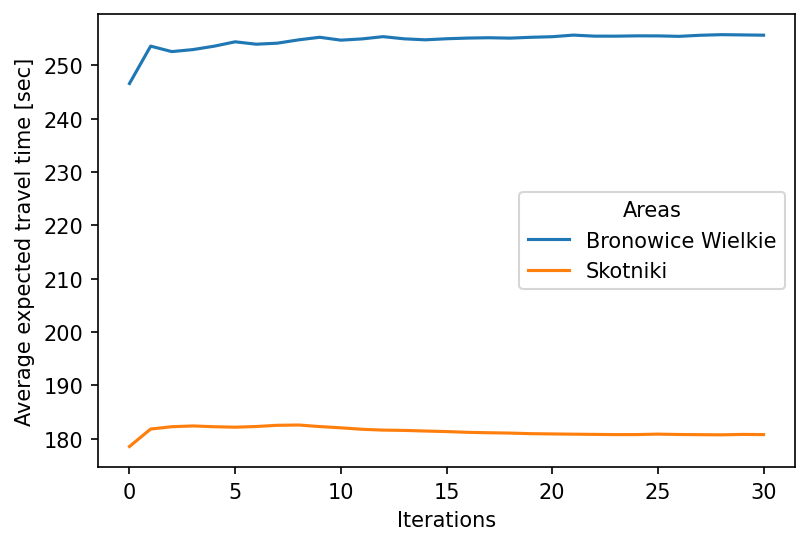

In [43]:
plt.figure(dpi=150)
plt.plot(ts_b, label='Bronowice Wielkie')
plt.plot(ts_s, label='Skotniki')
plt.xlabel('Iterations')
plt.ylabel('Average expected travel time [sec]')
plt.legend(title="Areas")
plt.show()

Convergence graph for SUM travelers in 1000 iterations
<br>NO convergence, white noise

In [ ]:
t_b_1000 = avg_times['Bronowice Wielkie']
t_s_1000 = avg_times['Skotniki']

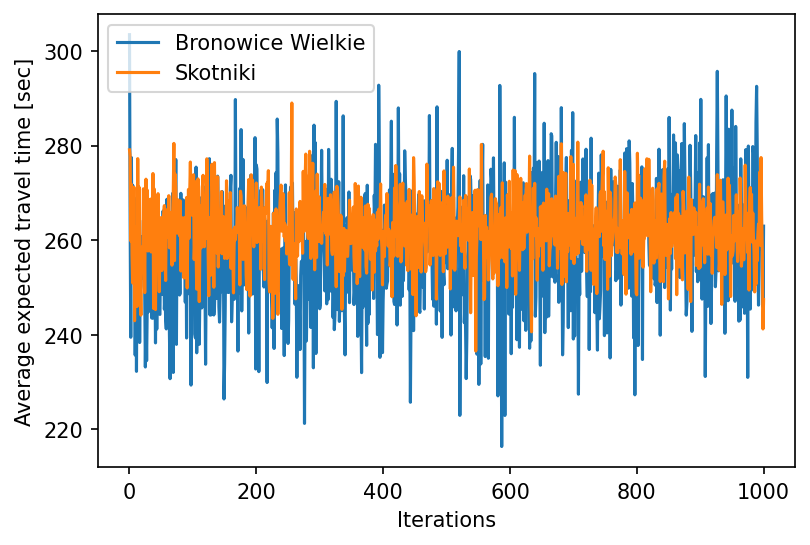

In [21]:
plt.figure(dpi=150)
plt.plot(t_b_1000, label='Bronowice Wielkie')
plt.plot(t_s_1000, label='Skotniki')
plt.xlabel('Iterations')
plt.ylabel('Average expected travel time [sec]')
plt.legend()
plt.show()

Convergence graph for ALL travelers in 30 iterations
<br>table df_sum

In [12]:
t_b = avg_times['Bronowice Wielkie']
t_s = avg_times['Skotniki']

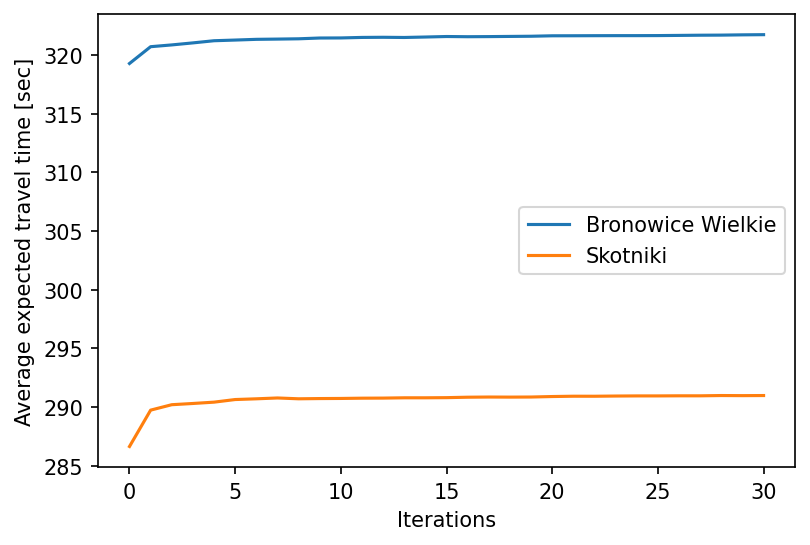

In [14]:
plt.figure(dpi=150)
plt.plot(t_b, label='Bronowice Wielkie')
plt.plot(t_s, label='Skotniki')
plt.xlabel('Iterations')
plt.ylabel('Average expected travel time [sec]')
plt.legend()
plt.show()